# Analyzing NYC High School Data
We will work with the fillowing interrelated data sets about New York City public schools:

- [SAT scores by school](https://data.cityofnewyork.us/Education/2012-SAT-Results/f9bf-2cp4) - SAT scores for each high school in New York City

- [SAT scores by school](https://data.cityofnewyork.us/Education/2010-2011-School-Attendance-and-Enrollment-Statist/7z8d-msnt) - Attendance information for each school in New York City

- [Class size](https://data.cityofnewyork.us/Education/2010-2011-Class-Size-School-level-detail/urz7-pzb3) - Information on class size for each school

- [AP test results](https://data.cityofnewyork.us/Education/2010-AP-College-Board-School-Level-Results/itfs-ms3e) - Advanced Placement (AP) exam results for each high school

- [Graduation outcomes](https://data.cityofnewyork.us/Education/2005-2010-Graduation-Outcomes-School-Level/vh2h-md7a) - The percentage of students who graduated, and other outcome information

- [Demographics](https://data.cityofnewyork.us/Education/2006-2012-School-Demographics-and-Accountability-S/ihfw-zy9j) - Demographic information for each school

- [School survey](https://data.cityofnewyork.us/Education/2011-NYC-School-Survey/mnz3-dyi8) - Surveys of parents, teachers, and students at each school

### Reading in the data

In [5]:
# reading in the CSV files

import pandas as pd
data_files = ["ap_2010.csv",
"class_size.csv",
"demographics.csv",
"graduation.csv",
"hs_directory.csv",
"sat_results.csv"]
data = {}
for file in data_files:
    data[file.replace('.csv', '')] = pd.read_csv(file)


In [17]:
# Reading in the survey data

all_survey = pd.read_csv("survey_all .txt",delimiter="\t",encoding="windows-1252")
d75_survey = pd.read_csv("survey_d75.txt",delimiter="\t",encoding="windows-1252")
survey = pd.concat([all_survey,d75_survey],axis=0,sort=True)


### Cleaning the Data

In [72]:
# Cleaning Up the Surveys

survey["DBN"]=survey["DBN"]
survey = survey.loc[:,["DBN","rr_s", "rr_t", "rr_p", "N_s", "N_t", "N_p", "saf_p_11", "com_p_11", "eng_p_11", "aca_p_11", "saf_t_11", "com_t_11", "eng_t_11", "aca_t_11", "saf_s_11", "com_s_11", "eng_s_11", "aca_s_11", "saf_tot_11", "com_tot_11", "eng_tot_11", "aca_tot_11"]]
data["survey"] = survey

In [37]:
# Inserting DBN Fields

data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad(n):
    if len(str(n)) > 1:
        return str(n)
    else:

        return str(n).zfill(2)
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]
data['class_size']['DBN']

0        01M015
1        01M015
2        01M015
3        01M015
4        01M015
          ...  
27606    32K564
27607    32K564
27608    32K564
27609    32K564
27610    32K564
Name: DBN, Length: 27611, dtype: object

In [40]:
# Combining the SAT Scores

cols = ["SAT Math Avg. Score","SAT Critical Reading Avg. Score","SAT Writing Avg. Score"]
for col in cols:
    data["sat_results"][col] = pd.to_numeric(data["sat_results"][col],errors="coerce")

data["sat_results"]["sat_score"] = data["sat_results"][cols[0]] + data["sat_results"][cols[1]] + data["sat_results"][cols[2]]

In [42]:
# Parsing Geographic Coordinates for Schools

import re

def get_lat(location):
    return re.findall("\(.+\)",location)[0].split(",")[0].replace('(',"")

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(get_lat)

def get_lon(location):
    return re.findall("\(.+\)",location)[0].split(",")[1].replace(')',"")

data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(get_lon)

### Condensing the Class Size Data Set

In [46]:
class_size = data['class_size']
class_size = class_size[class_size['GRADE '] == '09-12']
class_size = class_size[class_size['PROGRAM TYPE'] == 'GEN ED']

### Condensing the Demographics Data Set

In [60]:
demographics = data["demographics"]
demographics = demographics[demographics['schoolyear'] == 20112012]
demographics.head()

,DBN,Name,schoolyear,fl_percent,frl_percent,total_enrollment,prek,k,grade1,grade2,...,black_num,black_per,hispanic_num,hispanic_per,white_num,white_per,male_num,male_per,female_num,female_per
6,01M015,P.S. 015 ROBERTO CLEMENTE,20112012,NaN,89.4,189,13,31,35,28,...,63,33.3,109,57.7,4,2.1,97.0,51.3,92.0,48.7
13,01M019,P.S. 019 ASHER LEVY,20112012,NaN,61.5,328,32,46,52,54,...,81,24.7,158,48.2,28,8.5,147.0,44.8,181.0,55.2
20,01M020,PS 020 ANNA SILVER,20112012,NaN,92.5,626,52,102,121,87,...,55,8.8,357,57.0,16,2.6,330.0,52.7,296.0,47.3
27,01M034,PS 034 FRANKLIN D ROOSEVELT,20112012,NaN,99.7,401,14,34,38,36,...,90,22.4,275,68.6,8,2.0,204.0,50.9,197.0,49.1
35,01M063,PS 063 WILLIAM MCKINLEY,20112012,NaN,78.9,176,18,20,30,21,...,41,23.3,110,62.5,15,8.5,97.0,55.1,79.0,44.9


In [61]:
data["demographics"] = demographics

In [62]:
data["graduation"] = data["graduation"][data["graduation"]['Cohort'] == '2006']
data["graduation"] = data["graduation"][data["graduation"]['Demographic'] == 'Total Cohort']

### Converting AP Test Scores

In [63]:
cols = ['AP Test Takers ', 'Total Exams Taken','Number of Exams with scores 3 4 or 5']
for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

### Performing the Left Joins

In [64]:
combined = data["sat_results"]
combined = combined.merge(data["ap_2010"], on='DBN',how= 'left')
combined = combined.merge(data["graduation"], on='DBN',how= 'left')

### Performing the Inner Joins

In [65]:
to_merge = ['class_size', 'demographics', 'survey', 'hs_directory']

for i in to_merge:
    combined = combined.merge(data[i], on='DBN',how= 'inner')

### Filling in Missing Values

In [ ]:
combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

### Adding a School District Column for Mapping

In [67]:
def get_first_two(str):
    return str[0:2]
combined["school_dist"] = combined["DBN"].apply(get_first_two)
combined.head()

,DBN,SCHOOL NAME_x,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon,school_dist
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355.0,404.0,363.0,1122.0,NaN,NaN,NaN,...,Then to New York City residents,NaN,NaN,NaN,NaN,NaN,"220 Henry Street\nNew York, NY 10002\n(40.7137...",40.71376394700047,-73.98526003999967,01
1,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355.0,404.0,363.0,1122.0,NaN,NaN,NaN,...,Then to New York City residents,NaN,NaN,NaN,NaN,NaN,"220 Henry Street\nNew York, NY 10002\n(40.7137...",40.71376394700047,-73.98526003999967,01
2,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355.0,404.0,363.0,1122.0,NaN,NaN,NaN,...,Then to New York City residents,NaN,NaN,NaN,NaN,NaN,"220 Henry Street\nNew York, NY 10002\n(40.7137...",40.71376394700047,-73.98526003999967,01
3,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355.0,404.0,363.0,1122.0,NaN,NaN,NaN,...,Then to New York City residents,NaN,NaN,NaN,NaN,NaN,"220 Henry Street\nNew York, NY 10002\n(40.7137...",40.71376394700047,-73.98526003999967,01
4,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355.0,404.0,363.0,1122.0,NaN,NaN,NaN,...,Then to New York City residents,NaN,NaN,NaN,NaN,NaN,"220 Henry Street\nNew York, NY 10002\n(40.7137...",40.71376394700047,-73.98526003999967,01


# Exploring the Data
### Finding correlations

In [69]:
correlations = combined.corr()
correlations = correlations["sat_score"]
correlations

C:\Users\Rabo Yusuf\AppData\Local\Temp\ipykernel_12796\2642224973.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlations = combined.corr()


SAT Critical Reading Avg. Score    0.985064
SAT Math Avg. Score                0.971335
SAT Writing Avg. Score             0.985410
sat_score                          1.000000
AP Test Takers                     0.618849
                                     ...   
grade_span_max                          NaN
expgrade_span_max                       NaN
zip                               -0.043800
total_students                     0.433098
number_programs                    0.158060
Name: sat_score, Length: 61, dtype: float64

### Plotting survey correlations

<Axes: >

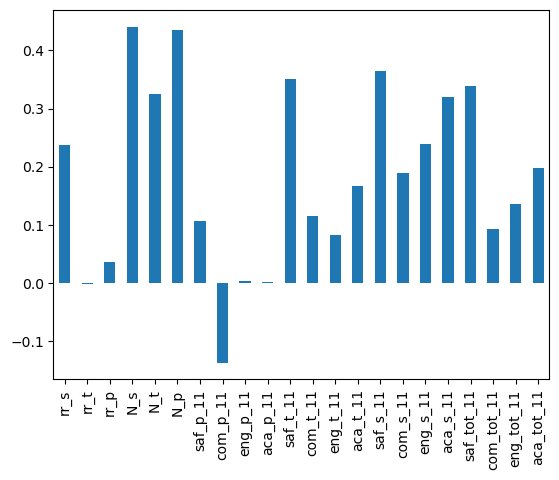

In [73]:
import warnings
warnings.filterwarnings('ignore')
survey_fields = ["rr_s", "rr_t", "rr_p", "N_s", "N_t", "N_p", "saf_p_11", "com_p_11", "eng_p_11", "aca_p_11", "saf_t_11", "com_t_11", "eng_t_11", "aca_t_11", "saf_s_11", "com_s_11", "eng_s_11", "aca_s_11", "saf_tot_11", "com_tot_11", "eng_tot_11", "aca_tot_11"]
combined.corr()["sat_score"][survey_fields].plot.bar()

### Exploring Safety and SAT Scores

<Axes: xlabel='saf_s_11', ylabel='sat_score'>

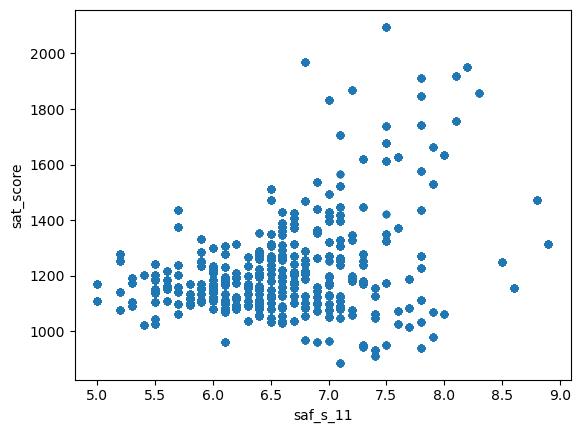

In [74]:
combined.plot.scatter("saf_s_11", "sat_score")